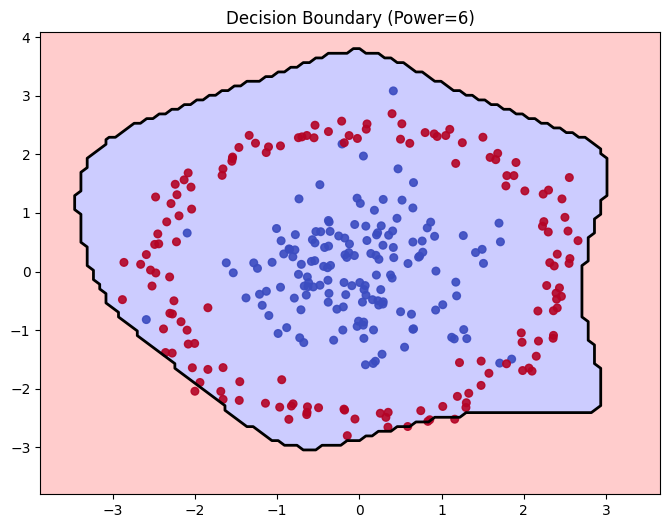

Accuracy: 98.67%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Stabilized sigmoid function
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

# Stabilized loss function
def loss(theta, X, y):
    h = sigmoid(X @ theta)
    h = np.clip(h, 1e-15, 1-1e-15)  # Avoid log(0)
    return (-y.T @ np.log(h) - (1-y).T @ np.log(1-h)).item() / len(y)

# Stabilized gradient
def grad(theta, X, y):
    h = sigmoid(X @ theta)
    return (X.T @ (h - y)) / len(y)

# Feature expansion with scaling
def expand_feature(x1, x2, power=2):
    # Scale features before polynomial expansion
    x1 = (x1 - x1.mean()) / x1.std()
    x2 = (x2 - x2.mean()) / x2.std()
    
    new_x = np.ones((x1.shape[0], 1))
    for i in range(1, power + 1):
        for j in range(i + 1):
            new_x = np.hstack((new_x, (x1**(i-j) * (x2**j)).reshape(-1,1)))
    return new_x

# Gradient descent with learning rate decay
def gradient_descent(X, y, theta, alpha, num_iters):
    costs = []
    for i in range(num_iters):
        theta -= alpha * grad(theta, X, y)
        costs.append(loss(theta, X, y))
        
        # Learning rate decay
        alpha *= 0.9999
        
        # Early stopping if cost doesn't improve
        if len(costs) > 10 and abs(costs[-1] - costs[-10]) < 1e-9:
            break
            
    return theta, costs

def predict(theta, X):
    return (sigmoid(X @ theta) >= 0.5).astype(int)

def logistic_regression(X, y, power=6, alpha=0.3, num_iters=10000):
    X_expanded = expand_feature(X[:,0], X[:,1], power=power)
    theta = np.zeros((X_expanded.shape[1], 1))
    theta, costs = gradient_descent(X_expanded, y, theta, alpha, num_iters)
    predicted = predict(theta, X_expanded)
    return predicted, theta, costs

# Run with safer parameters
power = 6  # Reduced from 20 to prevent overfitting
num_iters = 10000
alpha = 0.3  # Reduced learning rate with decay

predicted, theta, costs = logistic_regression(X, y, power=power, alpha=alpha, num_iters=num_iters)

# Plot decision boundary
def plot_decision_boundary(X, y, theta, power):
    u = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
    v = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100)
    U, V = np.meshgrid(u, v)
    grid_expanded = expand_feature(U.ravel(), V.ravel(), power=power)
    Z = predict(theta, grid_expanded).reshape(U.shape)
    
    plt.figure(figsize=(8,6))
    plt.contourf(U, V, Z, alpha=0.2, levels=[-0.5, 0.5, 1.5], colors=['blue','red'])
    plt.contour(U, V, Z, levels=[0.5], colors='black', linewidths=2)
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=30, alpha=0.9)
    plt.title(f'Decision Boundary (Power={power})')
    plt.show()

plot_decision_boundary(X, y, theta, power)

# Calculate accuracy
accuracy = np.mean(predicted == y) * 100
print(f"Accuracy: {accuracy:.2f}%")

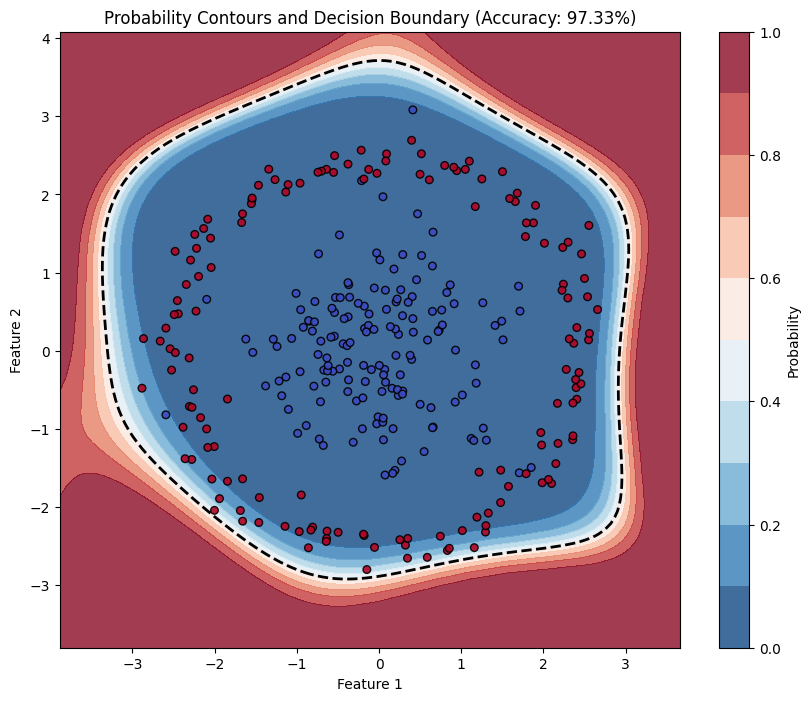

In [62]:
def plot_probability_contour(X, y, theta, power):
    # Create grid
    u = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
    v = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100)
    U, V = np.meshgrid(u, v)
    
    # Expand features and compute probabilities
    grid_expanded = expand_feature(U.ravel(), V.ravel(), power=power)
    Z = sigmoid(grid_expanded @ theta).reshape(U.shape)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Plot probability contours
    contours = plt.contourf(U, V, Z, levels=np.linspace(0, 1, 11), cmap='RdBu_r', alpha=0.8)
    plt.colorbar(contours, label='Probability')
    
    # Add decision boundary at 0.5 probability
    plt.contour(U, V, Z, levels=[0.5], colors='black', linewidths=2, linestyles='dashed')
    
    # Plot data points
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=30, edgecolors='k', alpha=0.9)
    
    plt.title(f'Probability Contours and Decision Boundary (Accuracy: {accuracy:.2f}%)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Call the function with your trained model
plot_probability_contour(X, y, theta, power)

now let us start regularization 

Regularization : Cost Function 

In [58]:

def sigmoid(z):
    # Numerically stable sigmoid
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

def cost_reg(theta, X, y, lam=0):
    h = sigmoid(X @ theta)
    h = np.clip(h, 1e-15, 1-1e-15)  # Avoid log(0)
    theta1 = theta.copy()
    theta1[0] = 0  # Don't regularize bias term
    term1 = -y.T @ np.log(h)
    term2 = (1-y).T @ np.log(1-h)
    reg = (lam/(2*len(y))) * np.sum(theta1**2)
    return (term1 - term2)/len(y) + reg

def grad_reg(theta, X, y, lam=0):
    h = sigmoid(X @ theta)
    theta1 = theta.copy()
    theta1[0] = 0  # Don't regularize bias term
    return (X.T @ (h - y) + lam * theta1)/len(y)

def gradient_descent_reg(X, y, theta, alpha, lam=0, num_iters=100):
    costs = []
    m = len(y)
    
    for _ in range(num_iters):
        h = sigmoid(X @ theta)
        theta1 = theta.copy()
        theta1[0] = 0
        grad = (X.T @ (h - y) + lam * theta1)/m
        theta -= alpha * grad
        costs.append(cost_reg(theta, X, y, lam))
        
        # Early stopping if cost doesn't improve
        if len(costs) > 10 and abs(costs[-1] - costs[-10]) < 1e-9:
            break
            
    return theta, costs

def logistic_regression_reg(X, y, power=2, alpha=0.01, lam=0, num_iters=100):
    # Scale features before polynomial expansion
    X_scaled = np.column_stack([
        (X[:,0] - X[:,0].mean())/X[:,0].std(),
        (X[:,1] - X[:,1].mean())/X[:,1].std()
    ])
    
    X_expanded = expand_feature(X_scaled[:,0], X_scaled[:,1], power=power)
    theta = np.zeros((X_expanded.shape[1], 1))
    
    theta, costs = gradient_descent_reg(X_expanded, y, theta, alpha, lam, num_iters)
    predicted = predict(theta, X_expanded)
    return predicted, theta, costs

# Safer parameters
power = 6  # Reduced from 20 to prevent overfitting
num_iters = 10000
lam = 0.5  # Regularization strength
alpha = 0.3  # Learning rate

predicted, theta, costs = logistic_regression_reg(
    X, y, power=power, alpha=alpha, lam=lam, num_iters=num_iters
)

# Calculate accuracy
accuracy = np.mean(predicted == y) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.33%
